In [44]:
import pypsa
import pandas as pd
import numpy as np

In [45]:
solver = "highs"

In [46]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

#### Initialize network

*** 
Check-point 1:

**Build a network in PyPSA with three nodes (`bus`) and the following components to model a simple green hydrogen production system:**

1. An `Electricity` bus with electricity as `carrier`.
   1. A wind generator connected to this bus.
   2. A solar generator connected to this bus.
2. A `Hydrogen` bus with hydrogen as `carrier`.
   1. A hydrogen demand load connected to this bus.
3. An electrolyser link to convert electricity into hydrogen.
4. A `Hydrogen_storage` bus with hydrogen as `carrier`.
   1. A hydrogen store connected to this bus.
5. A bi-directional link to transfer the hydrogen between hydrogen and hydrogen storage buses.

**For simplicity, we assume the hydrogen demand profile to be flat for now. Afterwards, we want to supply electricy by attaching one renewable power plant implemented as (`generator`) (you have to call [`network.set_snapshots`](https://pypsa.readthedocs.io/en/latest/api/_source/pypsa.Network.set_snapshots.html) to select a year). As help you should have a look at the [PyPSA documentation](https://pypsa.readthedocs.io/en/latest/) and the [minimal lopf example](https://pypsa.readthedocs.io/en/latest/examples/minimal_example_pf.html), understand what the [components documentation](https://pypsa.readthedocs.io/en/latest/user-guide/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [LOPF documentation](https://pypsa.readthedocs.io/en/stable/user-guide/optimal-power-flow.html).**

> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

<img src="../../data/block diagrams/d2_e3-1.svg" width=600/>

In [47]:
# Create empty PyPSA network
network = pypsa.Network(name="d2_h2_system_example_3")

In [48]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023", "01-01-2024", freq="h", inclusive="left")
network.set_snapshots(snapshots)

In [49]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='h')

In [50]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv(
    "../../data/weather data/example_onshore_wind_daily_pattern.csv"
)["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern) * 365, index=network.snapshots)

In [51]:
# Import an example of solar daily pattern
solar_pattern = pd.read_csv("../../data/weather data/example_solar_daily_pattern.csv")[
    "daily pattern"
]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern) * 365, index=network.snapshots)

Add an `electricity` bus with electricity as `carrier`

In [52]:
network.add(class_name="Bus", name="electricity", carrier="electricity")

Index(['electricity'], dtype='object')

Add a `hydrogen` bus with hydrogen as `carrier`

In [53]:
network.add(class_name="Bus", name="hydrogen", carrier="hydrogen")

Index(['hydrogen'], dtype='object')

Add a `hydrogen_storage` bus with hydrogen as `carrier`

In [54]:
network.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen")

Index(['hydrogen_storage'], dtype='object')

In [55]:
network.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,,1.0,0.0,inf,PQ,,


Add a constant hourly hydrogen load of `100MW` at the hydrogen bus. The name of the load can be `hydrogen_load`

In [56]:
network.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100)

Index(['hydrogen_load'], dtype='object')

In [57]:
network.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
hydrogen_load,hydrogen,,,100.0,0.0,-1.0,True


Add a store at the hydrogen_storage bus with a initial energy capacity of `0MWh`, and marginal cost of `0$/MWh` into the network. The name of the store can be `hydrogen_tank`. 

In [58]:
network.add(
    class_name="Store",
    name="hydrogen_tank",
    bus="hydrogen_storage",
    carrier="hydrogen",
    e_nom_extendable=True,
    e_cyclic=True,
    marginal_cost=0.01,  # $/MWh
)

Index(['hydrogen_tank'], dtype='object')

Add a bidirectional link, representing the hydrogen charging and discharging between hydrogen and hydrogen_storage with marginal cost of `0$/MWh` into the network? The name of the link can be `hydrogen_flow`. 

In [59]:
network.add(
    class_name="Link",
    name="hydrogen_flow",
    bus0="hydrogen",
    bus1="hydrogen_storage",
    p_nom_extendable=True,
    marginal_cost=0.01,  # $/MWh
    efficiency=1,
    p_min_pu=-1,
)

Index(['hydrogen_flow'], dtype='object')

Add a wind generator at the electricity bus with a initial capacity of `100MW`, maximum capacity of `500MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime? The name of the generator can be `onshore_wind`. 

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [60]:
# Onshore Wind's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 25
interest = 0.05

CAPEX = 1420 * eur_to_usd  # $/MW
FOM = 28 * eur_to_usd  # $/MW fixed
VOM = 0.01  # $/MWh variable

efficiency = 1

In [61]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Generator",
    name="onshore_wind",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom=100,  # MW
    p_nom_max=500,  # MW
    capital_cost=annualized_capex + FOM,  # $/MW
    marginal_cost=VOM,  # $/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile,
)

Index(['onshore_wind'], dtype='object')

Add a solar generator at the electricity bus with a initial capacity of `10MW`, maximum capacity of `500MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime? The name of the generator can be `solar`. 

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [62]:
# Solar's techno-economic parameters are given as:
eur_to_use = 1.1
lifetime = 20
interest = 0.05

CAPEX = 970 * eur_to_use  # $/MW
FOM = 16 * eur_to_use  # $/MW fixed
VOM = 0.01  # $/MWh variable

efficiency = 1

In [63]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Generator",
    name="solar",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom=50,
    p_nom_max=500,  # MW
    capital_cost=annualized_capex + FOM,  # $/MW
    marginal_cost=VOM,  # $/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile,
)

Index(['solar'], dtype='object')

In [64]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,100.0,0.0,True,0.0,500.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,50.0,0.0,True,0.0,500.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Add an electrolyser link, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [65]:
# Electrolyser's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.05

CAPEX = 1590 * eur_to_usd  # $/MW
FOM = 32 * eur_to_usd  # $/MW fixed
VOM = 0.01  # $/MWh variable
efficiency = 0.59

In [66]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom=20,
    capital_cost=annualized_capex + FOM,  # $/MW
    marginal_cost=VOM,  # $/MWh
    efficiency=efficiency,
    lifetime=lifetime,
)

Index(['electrolyser'], dtype='object')

Now try to solve your network

In [67]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

Index(['hydrogen_flow', 'electrolyser'], dtype='object', name='Link')
Index(['hydrogen_tank'], dtype='object', name='Store')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['electricity', 'hydrogen', 'hydrogen_storage'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, -13.88it/s]
INFO:linopy.io: Writing time: 2.19s


ERROR:   getOptionIndex: Option "pyomo" is unknown
Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-e_aoj58u has 122647 rows; 52566 cols; 223022 nonzeros
Coefficient ranges:
  Matrix  [2e-02, 1e+00]
  Cost    [1e-02, 2e+02]
  Bound   [2e+04, 2e+04]
  RHS     [1e+02, 5e+02]
Presolving model
34310 rows, 25553 cols, 81395 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
30295 rows, 21538 cols, 77380 nonzeros  0s
Presolve reductions: rows 30295(-92352); columns 21538(-31028); nonzeros 77380(-145642) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.8674891088e+01 Ph1: 3306(3735.59); Du: 1102(18.6749) 0s
       9346    -2.6198429350e+03 Pr: 8318(3.46118e+09); Du: 0(6.23939e-08) 6s
      12832     3.8325448033e+03 Pr: 5

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 122647 duals
Objective: 1.81e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.



Model name          : linopy-problem-e_aoj58u
Model status        : Optimal
Simplex   iterations: 25612
Objective value     :  1.8081655529e+05
P-D objective error :  1.5129989030e-14
HiGHS run time      :         46.31


('ok', 'optimal')

Lets look at some results! Back to read the docs. How would you look at results?

<Axes: xlabel='snapshot'>

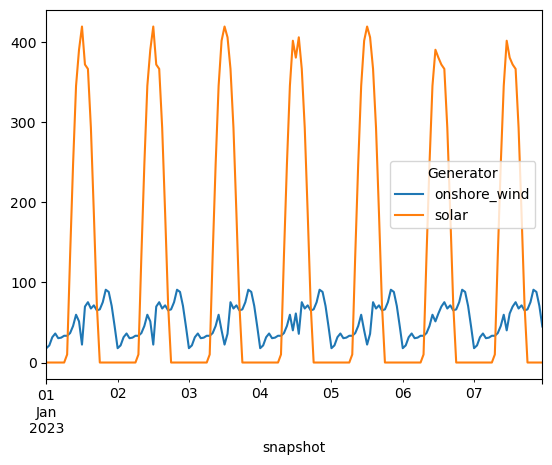

In [68]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[: 24 * 7].plot()

In [69]:
network.links_t.p0.head()

Link,hydrogen_flow,electrolyser
snapshot,,
2023-01-01 00:00:00,-89.461960,17.861084
2023-01-01 01:00:00,-87.407357,21.343463
2023-01-01 02:00:00,-81.388691,31.544592
2023-01-01 03:00:00,-78.651522,36.183861
2023-01-01 04:00:00,-82.101991,30.335608


In [70]:
network.links_t.p1.head()

Link,hydrogen_flow,electrolyser
snapshot,,
2023-01-01 00:00:00,89.461960,-10.538040
2023-01-01 01:00:00,87.407357,-12.592643
2023-01-01 02:00:00,81.388691,-18.611309
2023-01-01 03:00:00,78.651522,-21.348478
2023-01-01 04:00:00,82.101991,-17.898009


In [71]:
# Exporting check-point 1 network
network.export_to_netcdf("../../results/network_d2_e3-1.nc")

INFO:pypsa.network.io:Exported network 'd2_h2_system_example_3'saved to '../../results/network_d2_e3-1.nc contains: links, loads, stores, generators, buses


<xarray.Dataset> Size: 1MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   links_i: 2, links_t_p0_i: 2,
                                   links_t_p1_i: 2, loads_i: 1, loads_t_p_i: 1,
                                   stores_i: 1, stores_t_p_i: 1,
                                   stores_t_e_i: 1, generators_i: 2,
                                   generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 2, buses_i: 3,
                                   buses_t_p_i: 2, buses_t_marginal_price_i: 3)
Coordinates: (12/16)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) object 0B 
  * links_i                       (links_i) object 16B 'hydrogen_flow' 'elect...
  * links_t_p0_i                  (links_t_p0_i) object 16B 'hydrogen_flow' '...
  * links_t_p1_i                  (links_t_p1_i) object 16B 'hydrogen_flow' '...
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
    ...                            ...
  * generators_i                  (generators_i) object 16B 'onshore_wind' 's...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 16B 'onsho...
  * generators_t_p_i              (generators_t_p_i) object 16B 'onshore_wind...
  * buses_i                       (buses_i) object 24B 'electricity' ... 'hyd...
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 24B 'elec...
Data variables: (12/44)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    generators_p_nom_opt          (generators_i) float64 16B 316.8 500.0
    generators_t_p_max_pu         (snapshots, generators_t_p_max_pu_i) float64 140kB ...
    generators_t_p                (snapshots, generators_t_p_i) float64 140kB ...
    buses_carrier                 (buses_i) object 24B 'electricity' ... 'hyd...
    buses_t_p                     (snapshots, buses_t_p_i) float64 140kB 3.55...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 210kB ...
Attributes:
    network__linearized_uc:       0
    network__multi_invest:        0
    network__objective:           180816.5552852452
    network__objective_constant:  22834.601556693426
    network_name:                 d2_h2_system_example_3
    network_objective:            180816.5552852452
    network_objective_constant:   22834.601556693426
    network_pypsa_version:        0.35.2
    network_srid:                 4326
    crs:                          {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Wor...
    meta:                         {}

***
Check-point 2:

**Instead of the fixed hydrogen load add an hourly one at the hydrogen bus according to the daily pattern of industrial hydrogen demand (`100MW per hour` from 1am to 7pm, followed by a 5-hour shutdown). The name of the load can be `hydroge_load`**

**Then remove the electrolyser link from the previous exercise and replace it with a new electrolyser link including the compressor needed to pressurize the produced hydrogen. Cost assumptions and the efficiency of this component must be adjusted**

The block diagram representing the system remains the same as before:


<img src="../../data/block diagrams/d2_e3-1.svg" width=600/>

In [72]:
# Import check-point 1 network
network = pypsa.Network("../../results/network_d2_e3-1.nc")

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'd2_h2_system_example_3' has buses, generators, links, loads, stores


In [73]:
# remove hydrogen load from previous check-point
network.remove(class_name="Load", name="hydrogen_load")

In [74]:
# remove electrolyser link from previous check-point
network.remove(class_name="Link", name="electrolyser")

To set hourly hydrogen demand, you need to call [`network.set_snapshots`](https://pypsa.readthedocs.io/en/latest/api/_source/pypsa.Network.set_snapshots.html) to select a year. For help, please see the [PyPSA documentation](https://pypsa.readthedocs.io/en/latest/) and the [optimzation with Linopy](https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy.html). Make sure you understand what the [components documentation](https://pypsa.readthedocs.io/en/latest/user-guide/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [System Optimization documentation](https://pypsa.readthedocs.io/en/stable/user-guide/optimal-power-flow.html).

In [75]:
# Import an example of wind daily pattern
load_pattern = pd.read_csv(
    "../../data/weather data/example_industrial_h2_demand_daily_pattern.csv"
)["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
load_profile = pd.Series(list(load_pattern) * 365, index=network.snapshots)

In [76]:
network.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=load_profile)

Index(['hydrogen_load'], dtype='object')

Add an electrolyser link including compressor, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, water_cost, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [77]:
# Electrolyser's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.05
water_cost = 1.8  # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
water_demand_ratio = (
    21  # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?
)

CAPEX = 1590 * eur_to_usd  # $/MW
FOM = 32 * eur_to_usd  # $/MW fixed
VOM = 0.01  # $/MWh variable
efficiency = 0.59

# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] =
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (
    33.33 / 1000
)  # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = (
    0.6 / 33.33
)  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency  # unit: kWh_el/kWh_H2
new_efficiency = 1 / (
    specific_consumption_compressor + specific_consumption_electrolyser
)

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd  # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0.01  # $/MWh variable

In [78]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom=20,
    capital_cost=annualized_capex + FOM + annualized_capex_com + FOM_COM,  # $/MW
    marginal_cost=VOM + water_cost + VOM_COM,  # $/MWh
    efficiency=new_efficiency,
    lifetime=lifetime,
)

Index(['electrolyser'], dtype='object')

Ending of check-point 2 - Solve network, analyse results and export network

In [79]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

Index(['hydrogen_flow', 'electrolyser'], dtype='object', name='Link')
Index(['hydrogen_tank'], dtype='object', name='Store')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['electricity', 'hydrogen', 'hydrogen_storage'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 78.35it/s]
INFO:linopy.io: Writing time: 2.08s


ERROR:   getOptionIndex: Option "pyomo" is unknown
Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-voz0sp3n has 122647 rows; 52566 cols; 223022 nonzeros
Coefficient ranges:
  Matrix  [2e-02, 1e+00]
  Cost    [1e-02, 3e+02]
  Bound   [3e+04, 3e+04]
  RHS     [1e+02, 5e+02]
Presolving model
34310 rows, 25553 cols, 81395 nonzeros  0s
29200 rows, 20443 cols, 75190 nonzeros  0s
Dependent equations search running on 6935 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
28470 rows, 19713 cols, 73730 nonzeros  0s
Presolve reductions: rows 28470(-94177); columns 19713(-32853); nonzeros 73730(-149292) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.3926123614e+03 Ph1: 3306(3775.27); Du: 1102(2392.61) 1s
       8652     1.4821628259e+06 Pr: 5905(1.74494e+09); Du: 0(2.88179e-07

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 122647 duals
Objective: 1.68e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='snapshot'>

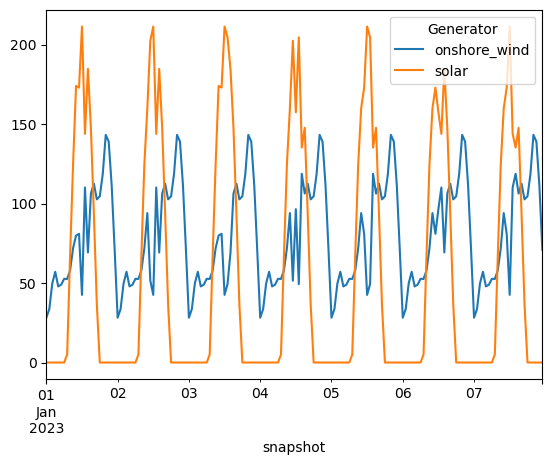

In [80]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[: 24 * 7].plot()

<Axes: xlabel='snapshot'>

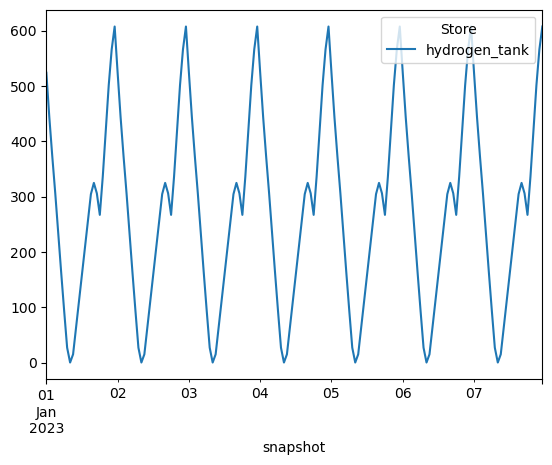

In [81]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
network.stores_t.e[: 24 * 7].plot()

<Axes: xlabel='snapshot'>

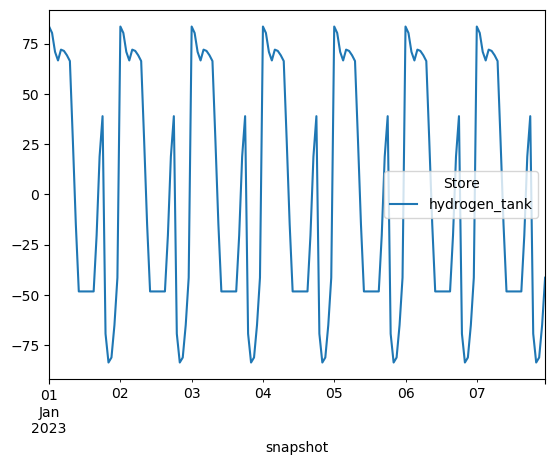

In [82]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
network.stores_t.p[: 24 * 7].plot()

<Axes: xlabel='snapshot'>

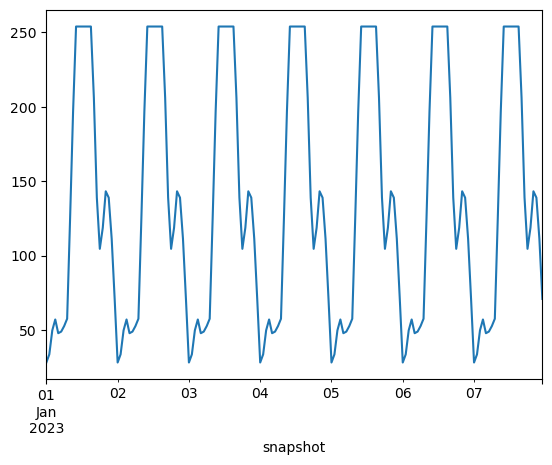

In [83]:
# Inspect the electrolysis input power
network.links_t.p0["electrolyser"][: 24 * 7].plot()

<Axes: xlabel='snapshot'>

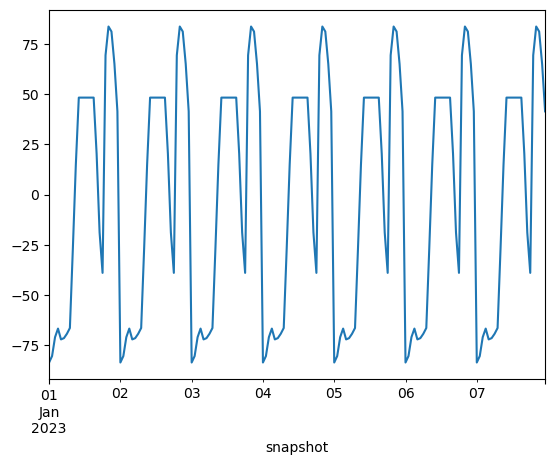

In [84]:
# Inspect the charging flow
network.links_t.p0["hydrogen_flow"][: 24 * 7].plot()

In [85]:
# Exporting check-point 2 network
network.export_to_netcdf("../../results/network_d2_e3-2.nc")

INFO:pypsa.network.io:Exported network 'd2_h2_system_example_3'saved to '../../results/network_d2_e3-2.nc contains: links, loads, stores, generators, buses


<xarray.Dataset> Size: 2MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   links_i: 2, links_t_p0_i: 2,
                                   links_t_p1_i: 2, loads_i: 1,
                                   loads_t_p_set_i: 1, loads_t_p_i: 1,
                                   stores_i: 1, stores_t_p_i: 1,
                                   stores_t_e_i: 1, generators_i: 2,
                                   generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 2, buses_i: 3,
                                   buses_t_p_i: 2, buses_t_marginal_price_i: 3)
Coordinates: (12/17)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) object 0B 
  * links_i                       (links_i) object 16B 'hydrogen_flow' 'elect...
  * links_t_p0_i                  (links_t_p0_i) object 16B 'hydrogen_flow' '...
  * links_t_p1_i                  (links_t_p1_i) object 16B 'hydrogen_flow' '...
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
    ...                            ...
  * generators_i                  (generators_i) object 16B 'onshore_wind' 's...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 16B 'onsho...
  * generators_t_p_i              (generators_t_p_i) object 16B 'onshore_wind...
  * buses_i                       (buses_i) object 24B 'electricity' ... 'hyd...
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 24B 'elec...
Data variables: (12/44)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) float64 0B 
    investment_periods_years      (investment_periods) float64 0B 
    ...                            ...
    generators_p_nom_opt          (generators_i) float64 16B 500.0 252.3
    generators_t_p_max_pu         (snapshots, generators_t_p_max_pu_i) float64 140kB ...
    generators_t_p                (snapshots, generators_t_p_i) float64 140kB ...
    buses_carrier                 (buses_i) object 24B 'electricity' ... 'hyd...
    buses_t_p                     (snapshots, buses_t_p_i) float64 140kB 0.0 ...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 210kB ...
Attributes:
    network__linearized_uc:       0
    network__multi_invest:        0
    network__objective:           1676335.8152791806
    network__objective_constant:  26267.442540896274
    network_name:                 d2_h2_system_example_3
    network_objective:            1676335.8152791806
    network_objective_constant:   26267.442540896274
    network_pypsa_version:        0.35.2
    network_srid:                 4326
    crs:                          {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Wor...
    meta:                         {}